In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import random 
import csv 
import time
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter, defaultdict
from pandas.plotting import scatter_matrix
sns.set(style="whitegrid")

## EVALUATION PARAMETERS

In [2]:
dataset2_size = 1000

# Class definition

In [3]:
def encode_column(df, column_name, new_column_name): 
        classes = [] 
        new_values = []
        df[new_column_name] = df[column_name]
        for i in range(len(df.index)): 
            if df.iloc[i][column_name] not in classes: 
                classes.append(df.iloc[i][column_name] ) 
        for i in range(len(classes)): 
            for j in range(len(df.index)): 
                if df.iloc[j][column_name] == classes[i]:
                    df.set_value(j, new_column_name, float(i))

        return df

In [4]:
class NaiveBayesDefinition():
    # the categorical class names are changed to numberic data 
    # eg: yes and no encoded to 1 and 0 
    def encode_class(self, mydata): 
        classes = [] 
        mapped_encoded_classes = []
        for i in range(len(mydata)): 
            if mydata[i][-1] not in classes: 
                classes.append(mydata[i][-1]) 
        for i in range(len(classes)): 
            mapped_encoded_classes.append(i)
            for j in range(len(mydata)): 
                if mydata[j][-1] == classes[i]: 
                    mydata[j][-1] = i
                    
        print(classes)
        print(mapped_encoded_classes)
        return mydata             


    # Splitting the data 
    def splitting(self, mydata, ratio): 
        train_num = int(len(mydata) * ratio) 
        train = [] 
        # initally testset will have all the dataset  
        test = list(mydata) 
        while len(train) < train_num: 
            # index generated randomly from range 0  
            # to length of testset 
            index = random.randrange(len(test)) 
            # from testset, pop data rows and put it in train 
            train.append(test.pop(index)) 
        return train, test 


    # Group the data rows under each class yes or  
    # no in dictionary eg: dict[yes] and dict[no]  
    def groupUnderClass(self, mydata): 
        dict = {} 
        for i in range(len(mydata)): 
            if (mydata[i][-1] not in dict): 
                dict[mydata[i][-1]] = [] 
            dict[mydata[i][-1]].append(mydata[i]) 
        return dict


    # Calculating Mean 
    def mean(self, numbers): 
        return sum(numbers) / float(len(numbers)) 

    # Calculating Standard Deviation 
    def std_dev(self, numbers): 
        avg = self.mean(numbers)
        if (len(numbers) <= 1):
            variance = sum([pow(x - avg, 2) for x in numbers]) / float(2 - 1) 
        else:
            variance = sum([pow(x - avg, 2) for x in numbers]) / float(len(numbers) - 1) 
        return math.sqrt(variance) 

    def trainClass(self, mydata): 
        info = [(self.mean(attribute), self.std_dev(attribute)) for attribute in zip(*mydata)] 
        # eg: list = [ [a, b, c], [m, n, o], [x, y, z]] 
        # here mean of 1st attribute =(a + m+x), mean of 2nd attribute = (b + n+y)/3 
        # delete summaries of last class 
        del info[-1] 
        return info 

    # find Mean and Standard Deviation under each class 
    def train(self, mydata): 
        info = {} 
        dict = self.groupUnderClass(mydata)
        for classValue, instances in dict.items():
            info[classValue] = self.trainClass(instances) 
        return info 


    # Calculate Gaussian Probability Density Function 
    def calculateGaussianProbability(self, x, mean, stdev): 
        if(stdev == 0):
            expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(1, 2))))
            return (1 / (math.sqrt(2 * math.pi) * 1)) * expo 
        else:
            expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev, 2)))) 
            return (1 / (math.sqrt(2 * math.pi) * stdev)) * expo 


    # Calculate Class Probabilities 
    def calculateClassProbabilities(self, info, test): 
        probabilities = {} 
        for classValue, classSummaries in info.items(): 
            probabilities[classValue] = 1
            for i in range(len(classSummaries)): 
                mean, std_dev = classSummaries[i] 
                x = test[i] 
                probabilities[classValue] *= self.calculateGaussianProbability(x, mean, std_dev) 
        return probabilities 


    # Make prediction - highest probability is the prediction 
    def predict(self, info, test): 
        probabilities = self.calculateClassProbabilities(info, test) 
        bestLabel, bestProb = None, -1
        for classValue, probability in probabilities.items(): 
            if bestLabel is None or probability > bestProb: 
                bestProb = probability 
                bestLabel = classValue 
        return bestLabel 


    # returns predictions for a set of examples 
    def getPredictions(self, info, test): 
        predictions = [] 
        for i in range(len(test)): 
            result = self.predict(info, test[i]) 
            predictions.append(result) 
        return predictions 

    # Accuracy score 
    def accuracy_rate(self, test, predictions): 
        correct = 0
        for i in range(len(test)): 
            if test[i][-1] == predictions[i]: 
                correct += 1
        return (correct / float(len(test))) * 100.0
    
    # Accuracy score 
    def error_avg(self, test, predictions): 
        correct = 0
        for i in range(len(test)): 
            if test[i][-1] == predictions[i]: 
                correct += 1
                
        errors = len(test) - correct
        return np.mean(errors)
    
    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()

# DATASET 1

## Read and clean dataset

In [5]:
df = pd.read_csv("Set1.txt", delimiter = "\t", names=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "Floor"])

In [6]:
df

,P1,P2,P3,P4,P5,P6,P7,Floor
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1
...,...,...,...,...,...,...,...,...
1995,-59,-59,-48,-66,-50,-86,-94,4
1996,-59,-56,-50,-62,-47,-87,-90,4
1997,-62,-59,-46,-65,-45,-87,-88,4
1998,-62,-58,-52,-61,-41,-90,-85,4


In [7]:
df.P1.mode()

0   -59
dtype: int64

In [8]:
df.P2.mode()

0   -56
dtype: int64

In [9]:
df.P3.mode()

0   -56
dtype: int64

In [10]:
df.P4.mode()

0   -59
dtype: int64

In [11]:
df.P5.mode()

0   -64
1   -63
dtype: int64

In [12]:
df.P6.mode()

0   -87
dtype: int64

In [13]:
df.P7.mode()

0   -85
dtype: int64

In [14]:
df_tmp = df.apply(pd.Series.value_counts)
df_tmp.div(df.shape[0] * 0.01 , axis=0)

,P1,P2,P3,P4,P5,P6,P7,Floor
-98,NaN,NaN,NaN,NaN,NaN,NaN,0.35,NaN
-97,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN
-96,NaN,NaN,NaN,NaN,NaN,0.30,0.05,NaN
-95,NaN,NaN,NaN,NaN,NaN,0.30,0.10,NaN
-94,NaN,NaN,NaN,NaN,NaN,0.30,0.50,NaN
...,...,...,...,...,...,...,...,...
-10,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0


## Perform analysis

### Prepare data

In [15]:
model = NaiveBayesDefinition()

In [16]:
# set features and target
mydata = df.values.tolist() 
mydata = model.encode_class(mydata) 
for i in range(len(mydata)): 
    mydata[i] = [float(x) for x in mydata[i]] 

[1, 2, 3, 4]
[0, 1, 2, 3]


### Split into train and test data

In [17]:
# split ratio = 0.7  
# 70% of data is training data and 30% is test data used for testing 
ratio = 0.7
train_data, test_data = model.splitting(mydata, ratio) 
print('Total number of examples are: ', len(mydata)) 
print('Out of these, training examples are: ', len(train_data)) 
print("Test examples are: ", len(test_data)) 

Total number of examples are:  2000
Out of these, training examples are:  1400
Test examples are:  600


### Train model

In [18]:
start_time = time.time()

In [19]:
# prepare model 
info = model.train(train_data) 

In [20]:
train_time = time.time() - start_time
print("Trainning time is: ", train_time) 

Trainning time is:  0.33809566497802734


### Test model and get predictions

In [21]:
start_time = time.time()

In [22]:
# test model
predictions = model.getPredictions(info, test_data) 

In [23]:
prediction_time = time.time() - start_time
print("Prediction time is: ", prediction_time) 

Prediction time is:  0.2573115825653076


In [24]:
predictions

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

### Calculate accuracy

In [25]:
test_data

[[-64.0, -56.0, -61.0, -66.0, -71.0, -82.0, -81.0, 0.0],
 [-63.0, -65.0, -60.0, -63.0, -77.0, -81.0, -87.0, 0.0],
 [-64.0, -55.0, -63.0, -66.0, -76.0, -88.0, -83.0, 0.0],
 [-65.0, -60.0, -59.0, -63.0, -76.0, -86.0, -82.0, 0.0],
 [-67.0, -60.0, -66.0, -65.0, -75.0, -86.0, -87.0, 0.0],
 [-63.0, -57.0, -67.0, -66.0, -79.0, -86.0, -89.0, 0.0],
 [-65.0, -62.0, -62.0, -65.0, -77.0, -84.0, -85.0, 0.0],
 [-61.0, -54.0, -60.0, -61.0, -74.0, -87.0, -83.0, 0.0],
 [-65.0, -53.0, -60.0, -62.0, -69.0, -85.0, -83.0, 0.0],
 [-63.0, -57.0, -59.0, -67.0, -71.0, -82.0, -93.0, 0.0],
 [-68.0, -58.0, -65.0, -65.0, -76.0, -87.0, -82.0, 0.0],
 [-68.0, -58.0, -65.0, -67.0, -83.0, -89.0, -86.0, 0.0],
 [-66.0, -69.0, -63.0, -69.0, -79.0, -88.0, -86.0, 0.0],
 [-63.0, -58.0, -66.0, -68.0, -75.0, -90.0, -93.0, 0.0],
 [-62.0, -58.0, -57.0, -65.0, -70.0, -82.0, -91.0, 0.0],
 [-64.0, -51.0, -57.0, -67.0, -68.0, -84.0, -82.0, 0.0],
 [-64.0, -56.0, -64.0, -67.0, -77.0, -81.0, -85.0, 0.0],
 [-61.0, -55.0, -63.0, -64.0, -

In [26]:
accuracy = model.accuracy_rate(test_data, predictions) 
print("Accuracy of your model is: ", accuracy) 

Accuracy of your model is:  98.33333333333333


In [27]:
mean_error = model.error_avg(test_data, predictions)
print("Mean avg error of your model is: ", mean_error) 

Mean avg error of your model is:  10.0


In [28]:
labels = [item[-1] for item in test_data]

### Test other combinations

In [29]:
trainning_ratios = [0.15, 0.5, 0.7, 0.8]
for tmp_ratio in trainning_ratios:
    tmp_train_data, tmp_test_data = model.splitting(mydata, tmp_ratio) 
    print('Total number of examples are: ', len(mydata)) 
    print('Out of these, training examples are: ', len(tmp_train_data)) 
    print("Test examples are: ", len(tmp_test_data)) 
    
    # prepare model
    tmp_start_time = time.time()
    tmp_info = model.train(tmp_train_data) 
    tmp_train_time = time.time() - tmp_start_time
    print("Trainning time is: ", tmp_train_time) 
    
    # test model
    tmp_start_time = time.time()
    tmp_predictions = model.getPredictions(tmp_info, tmp_test_data) 
    tmp_test_time = time.time() - tmp_start_time
    print("Prediction time is: ", tmp_test_time) 
    
    tmp_accuracy = model.accuracy_rate(tmp_test_data, tmp_predictions) 
    print("Accuracy of your model is: ", tmp_accuracy) 
    
    tmp_mean_error = model.error_avg(tmp_test_data, tmp_predictions)
    print("Mean avg error of your model is: ", tmp_mean_error) 
    print()
    print()

Total number of examples are:  2000
Out of these, training examples are:  300
Test examples are:  1700
Trainning time is:  0.001995086669921875
Prediction time is:  0.12466621398925781
Accuracy of your model is:  98.05882352941177
Mean avg error of your model is:  33.0


Total number of examples are:  2000
Out of these, training examples are:  1000
Test examples are:  1000
Trainning time is:  0.004986763000488281
Prediction time is:  0.08976078033447266
Accuracy of your model is:  98.3
Mean avg error of your model is:  17.0


Total number of examples are:  2000
Out of these, training examples are:  1400
Test examples are:  600
Trainning time is:  0.005983829498291016
Prediction time is:  0.04986715316772461
Accuracy of your model is:  99.0
Mean avg error of your model is:  6.0


Total number of examples are:  2000
Out of these, training examples are:  1600
Test examples are:  400
Trainning time is:  0.009973526000976562
Prediction time is:  0.02892160415649414
Accuracy of your model is

### Visualization: https://towardsdatascience.com/introduction-to-data-visualization-in-python-89a54c97fbed

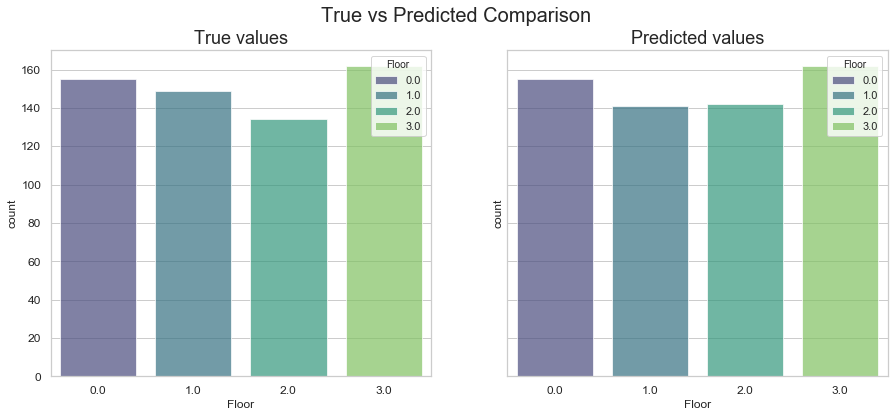

In [30]:
# Visualize labels in test data versus predictions and number of 
# equivalente values
model.visualize(labels, predictions, 'Floor')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E6DDA9588>,
      dtype=object)

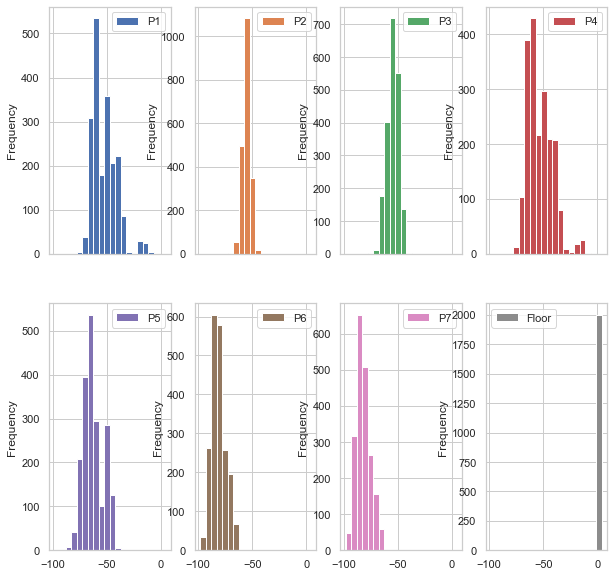

In [31]:
# Representation of value frequency
df.plot.hist(subplots=True, layout=(2,4), figsize=(10, 10), bins=20)

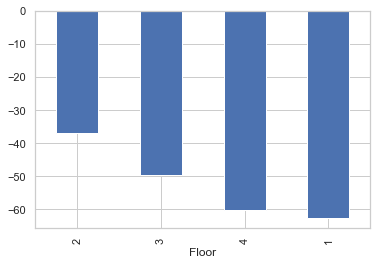

In [32]:
# Values of P1 for each floor
df.groupby("Floor").P1.mean().sort_values(ascending=False)[:5].plot.bar()

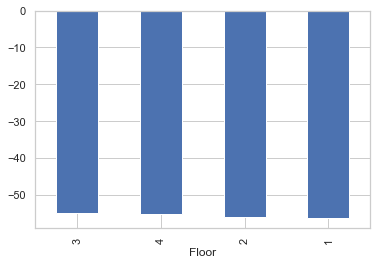

In [33]:
# Values of P2 for each floor
df.groupby("Floor").P2.mean().sort_values(ascending=False)[:5].plot.bar()

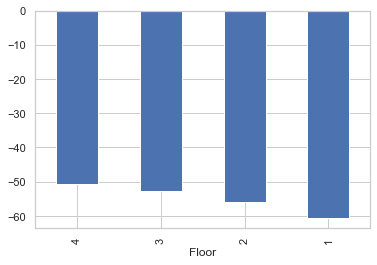

In [34]:
# Values of P3 for each floor
df.groupby("Floor").P3.mean().sort_values(ascending=False)[:5].plot.bar()

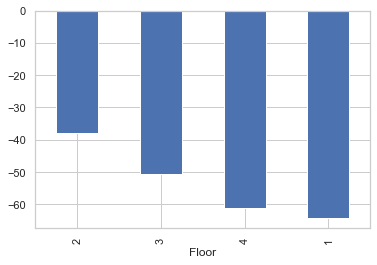

In [35]:
# Values of P2 for each floor
df.groupby("Floor").P4.mean().sort_values(ascending=False)[:5].plot.bar()

...

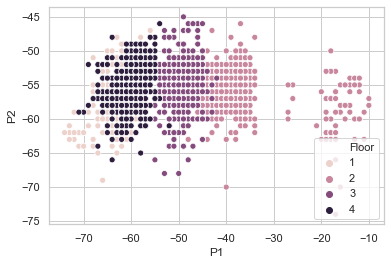

In [36]:
# Scatter of P1 - P2
sns.scatterplot(x='P1', y='P2', hue='Floor', data=df)

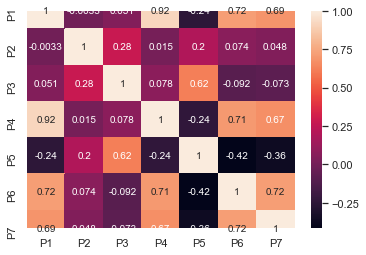

In [37]:
# Confusion matrix
sns.heatmap(df.drop(['Floor'], axis=1).corr(), annot=True)

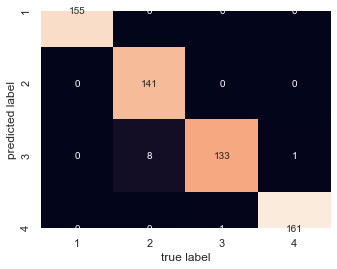

In [38]:
# Confusion matrix
floors = list(df['Floor'].unique())
mat = confusion_matrix(labels, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=floors, yticklabels=floors)
plt.xlabel('true label')
plt.ylabel('predicted label');

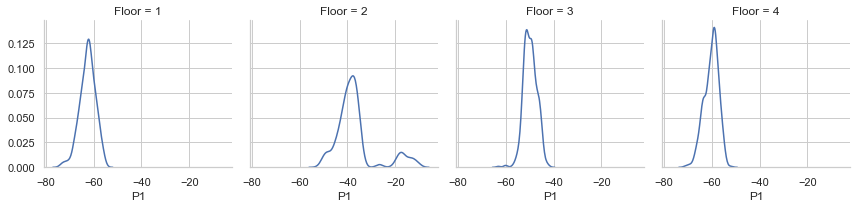

In [39]:
# Faceting is the act of breaking data variables up across multiple subplots 
# and combining those subplots into a single figure.
# In this case it will be the points of P1 per floor
g = sns.FacetGrid(df, col='Floor')
g = g.map(sns.kdeplot, 'P1')

C:\Users\Luis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019E6E4AB908>,
      dtype=object)

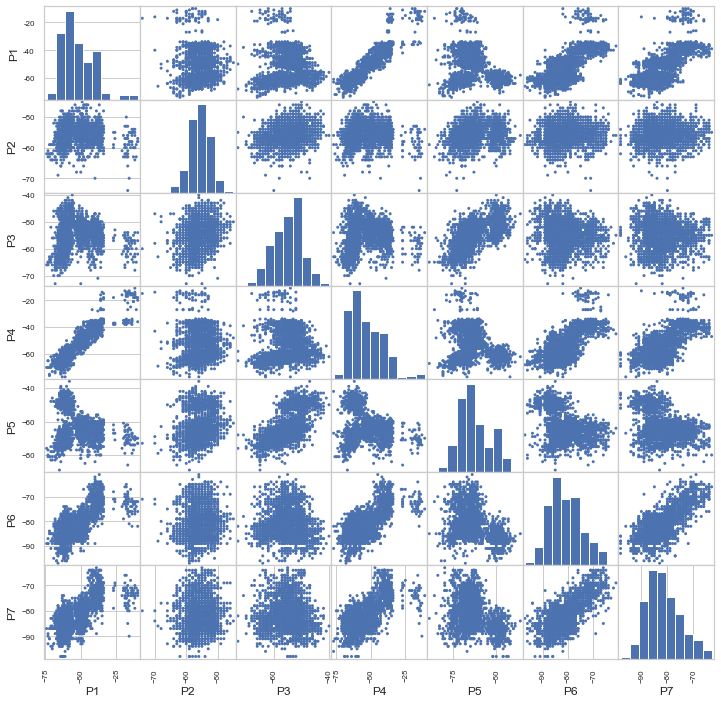

In [40]:
# Sparse matrix
fig, ax = plt.subplots(figsize=(12,12))
scatter_matrix(df.drop(['Floor'], axis=1), alpha=1, ax=ax)

# DATASET 2

## Read an clean dataset 

In [41]:
# read
#xl = pd.ExcelFile("Set2.xlsx")
#xl.sheet_names
#df = xl.parse("f3b1u17p22")
df = pd.read_excel("Set2.xlsx")

In [42]:
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-75412642999999200,4.864921e+16,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536621199999000,4.864934e+15,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519152399998150,4.864950e+15,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-75245703999996096,4.864934e+15,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632143599998200,4.864982e+15,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,-7485468600001180,4.864875e+15,3,1,1,2,18,10,1371710683
19933,100,100,100,100,100,100,100,100,100,100,...,100,-7390620600000020,4.864836e+15,1,2,140,2,18,10,1371710402
19934,100,100,100,100,100,100,100,100,100,100,...,100,-75168414999991600,4.864889e+15,3,1,13,2,18,10,1371710921
19935,100,100,100,100,100,100,100,100,100,100,...,100,-7537321899998930,4.864896e+15,3,1,113,2,18,10,1371711049


As the dataset is big and it could cause an overflow, we will limit it to 5000 elements

In [43]:
df = df[:dataset2_size]

In [44]:
df["FLOOR_BUILDING"] = df["FLOOR"].astype(str) + "_" + df["BUILDINGID"].astype(str)

C:\Users\Luis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
# Delete unnecesary columns
df = df.drop(labels=['FLOOR', 'BUILDINGID', 'SPACEID', 'USERID', 'PHONEID', 'TIMESTAMP'], axis=1)

In [46]:
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,RELATIVEPOSITION,FLOOR_BUILDING
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-75412642999999200,4.864921e+16,2,2_1
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7536621199999000,4.864934e+15,2,2_1
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,100,-7519152399998150,4.864950e+15,2,2_1
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-75245703999996096,4.864934e+15,2,2_1
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7632143599998200,4.864982e+15,2,0_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7571093400001520,4.864872e+16,2,2_1
996,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7559497299998990,4.864888e+15,2,2_1
997,100,100,100,100,100,100,100,-91,100,100,...,100,100,100,100,100,100,-7523628199998280,4.864952e+15,2,2_1
998,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7562186200000340,4.864867e+15,2,2_1


# Perform analysis

The analisis performed, conssits in a classification with naive bayes, that ....

### Prepare data

In [47]:
model2 = NaiveBayesDefinition()

In [48]:
# set features and target
mydata = df.values.tolist() 
mydata = model2.encode_class(mydata) 
for i in range(len(mydata) -1): 
    mydata[i] = [float(x) for x in mydata[i]] 

['2_1', '0_0', '3_2', '2_2']
[0, 1, 2, 3]


### Split into train and test data

In [49]:
# split ratio = 0.7  
# 70% of data is training data and 30% is test data used for testing 
ratio = 0.7
train_data, test_data = model2.splitting(mydata, ratio) 
print('Total number of examples are: ', len(mydata)) 
print('Out of these, training examples are: ', len(train_data)) 
print("Test examples are: ", len(test_data)) 

Total number of examples are:  1000
Out of these, training examples are:  700
Test examples are:  300


### Train model

In [50]:
# prepare model 
info = model2.train(train_data) 

### Test model and get predictions

In [51]:
# test model 
predictions = model2.getPredictions(info, test_data) 

### Calculate accuracy

In [52]:
accuracy = model2.accuracy_rate(test_data, predictions) 
print("Accuracy of your model is: ", accuracy) 

Accuracy of your model is:  41.333333333333336


In [53]:
mean_error = model.error_avg(test_data, predictions)
print("Mean avg error of your model is: ", mean_error) 

Mean avg error of your model is:  176.0


In [54]:
predictions

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [55]:
# 0 => '2_1', 1 => '0_0', 2=> '3_2', 3=>'2_2']
labels = [item[-1] for item in test_data]

In [56]:
### Test other combinations

In [57]:
trainning_ratios = [0.15, 0.5, 0.7, 0.8]
for tmp_ratio in trainning_ratios:
    tmp_train_data, tmp_test_data = model2.splitting(mydata, tmp_ratio) 
    print('Total number of examples are: ', len(mydata)) 
    print('Out of these, training examples are: ', len(tmp_train_data)) 
    print("Test examples are: ", len(tmp_test_data)) 
    
    # prepare model
    tmp_start_time = time.time()
    tmp_info = model2.train(tmp_train_data) 
    tmp_train_time = time.time() - tmp_start_time
    print("Trainning time is: ", tmp_train_time) 
    
    # test model
    tmp_start_time = time.time()
    tmp_predictions = model2.getPredictions(tmp_info, tmp_test_data) 
    tmp_test_time = time.time() - tmp_start_time
    print("Prediction time is: ", tmp_test_time) 
    
    tmp_accuracy = model2.accuracy_rate(tmp_test_data, tmp_predictions) 
    print("Accuracy of your model is: ", tmp_accuracy) 
    
    tmp_mean_error = model2.error_avg(tmp_test_data, tmp_predictions)
    print("Mean avg error of your model is: ", tmp_mean_error) 
    print()
    print()

Total number of examples are:  1000
Out of these, training examples are:  150
Test examples are:  850
Trainning time is:  0.015956878662109375
Prediction time is:  1.328446865081787
Accuracy of your model is:  55.17647058823529
Mean avg error of your model is:  381.0


Total number of examples are:  1000
Out of these, training examples are:  500
Test examples are:  500
Trainning time is:  0.0498659610748291
Prediction time is:  0.8606975078582764
Accuracy of your model is:  56.8
Mean avg error of your model is:  216.0


Total number of examples are:  1000
Out of these, training examples are:  700
Test examples are:  300
Trainning time is:  0.07081031799316406
Prediction time is:  0.3470728397369385
Accuracy of your model is:  53.333333333333336
Mean avg error of your model is:  140.0


Total number of examples are:  1000
Out of these, training examples are:  800
Test examples are:  200
Trainning time is:  0.08676815032958984
Prediction time is:  0.45976901054382324
Accuracy of your mod

### Visualization

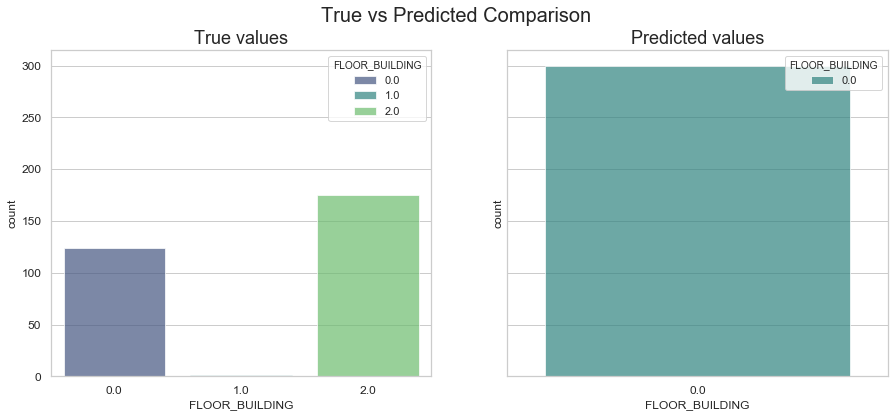

In [58]:
# Visualize labels in test data versus predictions and number of 
# equivalente values
model2.visualize(labels, predictions, 'FLOOR_BUILDING')

In [59]:
sub_df = encode_column(df, "FLOOR_BUILDING", "FLOOR_BUILDING_ENCODED")

C:\Users\Luis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [60]:
sub_df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,RELATIVEPOSITION,FLOOR_BUILDING,FLOOR_BUILDING_ENCODED
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-75412642999999200,4.864921e+16,2,2_1,0
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7536621199999000,4.864934e+15,2,2_1,0
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,-7519152399998150,4.864950e+15,2,2_1,0
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-75245703999996096,4.864934e+15,2,2_1,0
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7632143599998200,4.864982e+15,2,0_0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7571093400001520,4.864872e+16,2,2_1,0
996,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7559497299998990,4.864888e+15,2,2_1,0
997,100,100,100,100,100,100,100,-91,100,100,...,100,100,100,100,100,-7523628199998280,4.864952e+15,2,2_1,0
998,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-7562186200000340,4.864867e+15,2,2_1,0


In [61]:
# Scatter of P1 - P2
#sns.scatterplot(x='WAP005', y='WAP250', hue='FLOOR_BUILDING_ENCODED', data=sub_df)

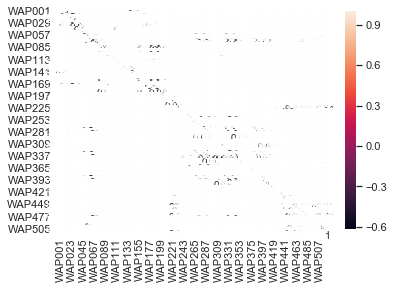

In [62]:
# Confusion matrix
sns.heatmap(sub_df.drop(['FLOOR_BUILDING_ENCODED'], axis=1).corr(), annot=True)

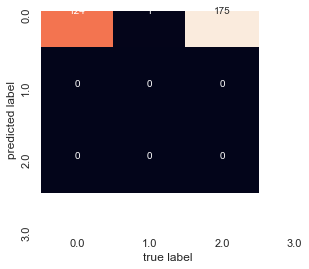

In [63]:
# Confusion matrix
floors = list(df['FLOOR_BUILDING_ENCODED'].unique())
mat = confusion_matrix(labels, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=floors, yticklabels=floors)
plt.xlabel('true label')
plt.ylabel('predicted label');

C:\Users\Luis\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Luis\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luis\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Luis\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


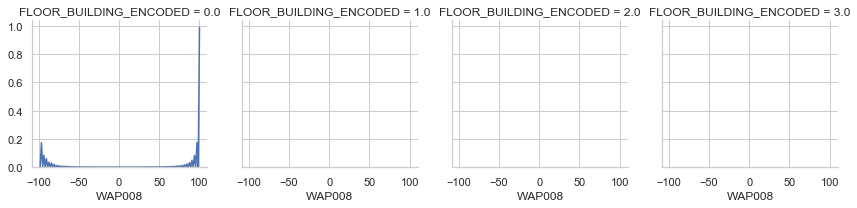

In [64]:
# Faceting is the act of breaking data variables up across multiple subplots 
# and combining those subplots into a single figure.
# In this case it will be the points of P1 per floor
g = sns.FacetGrid(sub_df, col='FLOOR_BUILDING_ENCODED')
g = g.map(sns.kdeplot, 'WAP008')

In [ ]:
# Sparse matrix
fig, ax = plt.subplots(figsize=(12,12))
scatter_matrix(sub_df.drop(['FLOOR_BUILDING_ENCODED'], axis=1), alpha=1, ax=ax)

C:\Users\Luis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until
